# Chest X-Ray (Pneumonia): CNN Network

New deeper CNN Structure The new CNN structure is based on the proposed by Amy MiHyun Jang
in https://keras.io/examples/vision/xray_classification_with_tpus/ \
This structure is deeper than the previous one it has 10 separable CNN layers organized in blocks. \
New callbacks have been programmed and they improve the training effectiveness of the network \
\
Train accuracy 96% \
Val accuracy 97% \
Test accuracy 85% \
ROC 95%

In [1]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to avoid warning messages

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import ELU, LeakyReLU,Activation

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

In [3]:
# We shuffle the original dataset and create val and test more balanced (0,6 train, 0.2 test, 0.2 val)
# folder structure 
#Notebook
#    !------ chest_xray_data
#                  !-------------normal
#                  !-------------pneumonia

train_normal = glob.glob("./chest_xray_data/normal/*.jpeg")
train_pneumonia = glob.glob("./chest_xray_data/pneumonia/*.jpeg")
print('there are ',len(train_normal),'normal images and', len(train_pneumonia),'pneumonia images')
COUNT_PNEUMONIA = len(train_pneumonia)
COUNT_NORMAL = len(train_normal)

there are  1583 normal images and 4273 pneumonia images


In [4]:
all_list = [x for x in train_normal]
all_list.extend([x for x in train_pneumonia])

df_all = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), 
                      columns = ['class'])
df_all['image'] = [x for x in all_list]
print(df_all.shape)

(5856, 2)


In [5]:
train_df, dummy_df = train_test_split(df_all, test_size = 0.33, random_state = SEED, 
                                    stratify = df_all['class'])
test_df, val_df = train_test_split(dummy_df, test_size = 0.50, random_state = SEED, 
                                    stratify = dummy_df['class'])

print('train',train_df.shape, 'test', test_df.shape, 'val', val_df.shape)

train (3923, 2) test (966, 2) val (967, 2)


### Data Preparation
We use ImageDataGenerator to perform data augmentation in the dataset. The final number of images is around 5000 but this number does not see enough for a good quality classifier. 

In [6]:
print ('shapes. Train: ',train_df.shape, 'val : ', val_df.shape, 'test : ',test_df.shape)
# https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(test_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

shapes. Train:  (3923, 2) val :  (967, 2) test :  (966, 2)
Found 3923 validated image filenames belonging to 2 classes.
Found 967 validated image filenames belonging to 2 classes.
Found 966 validated image filenames belonging to 2 classes.


## Class balancing using class weight parameter in keras

In [7]:
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))


Initial bias: 0.99299
Weight for class 0: 1.85
Weight for class 1: 0.69


### CNN
Data is ready. Now we define the CNN network and train 

In [8]:
#Setting callbakcs

initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0000001,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 10,                                   
    min_delt = 0.0000001,                                
    cooldown = 0,                               
    verbose = 1
) 

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)


### CNN structure

We will use block structure as in inception

In [9]:
# To ease the choice of activations we generate them from a single entry

def generate_activation(act_par):
    """
    Uses the value in the configuration to generate the activation layer
    :param act_par:
    :return:
    """

    if type(act_par) == list:
        if len(act_par) == 2:
            atype, par = act_par
            if atype == 'elu':
                return ELU(alpha=par)
            elif atype == 'leaky':
                return LeakyReLU(alpha=par)
            elif atype == 'prelu':
                return PReLU()
            else:
                raise NameError("No such Activation layer")
        elif len(act_par) == 1:
            return Activation(act_par[0])
        else:
            raise NameError("No such Activation layer")
    elif type(act_par) == str:
        return Activation(act_par)
    else:
        raise NameError("Wrong parameters for activation layer")
    return
generate_activation('relu')

In [10]:
# This example is with activation ELU 
activation_list = ["leaky",0.3]   # list of two or one components
activation_list = ["elu",0.1]   # list of two or one components
activation_list = ["relu"]   # list of two or one components

dropout_rate = 0.3 # dropout for CNN layers

# block definition

def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, padding="same")(inputs)
    x = generate_activation(activation_list)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.SeparableConv2D(filters, 3,  padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = generate_activation(activation_list)(x)
    outputs = layers.MaxPool2D()(x)

    return outputs

def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)

    return outputs

In [11]:
def block_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
#   x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3,  padding="same")(inputs)
    x = generate_activation(activation_list)(x)
    x = layers.Conv2D(16, 3, padding="same")(x)
    x = generate_activation(activation_list)(x)
    x = layers.MaxPool2D()(x)

    x = conv_block(32, x)
    x = conv_block(64, x)

    x = conv_block(128, x)
#    x = layers.Dropout(0.2)(x)

    x = conv_block(256, x)
#    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = dense_block(512, 0.7, x)
#    x = dense_block(128, 0.5, x)
    x = dense_block(64, 0.3, x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [12]:
keras.backend.clear_session()

model = block_model()
model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=lr_schedule), metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 activation (Activation)     (None, 224, 224, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 activation_1 (Activation)   (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                             

In [13]:
history = model.fit(ds_train,
          batch_size = BATCH, 
          epochs = 50,
          validation_data=ds_val,
          class_weight=class_weight,
          callbacks=[early_stopping_cb,checkpoint_cb]);

#         steps_per_epoch=(len(ds_train)/BATCH),
#         validation_steps=(len(ds_val)/BATCH)


Epoch 1/50
123/123 [==============================] - 460s 4s/step - loss: 0.5300 - binary_accuracy: 0.7471 - val_loss: 1.2596 - val_binary_accuracy: 0.3392
Epoch 2/50
123/123 [==============================] - 347s 3s/step - loss: 0.4047 - binary_accuracy: 0.8335 - val_loss: 2.3107 - val_binary_accuracy: 0.7270
Epoch 3/50
123/123 [==============================] - 328s 3s/step - loss: 0.3881 - binary_accuracy: 0.8348 - val_loss: 0.8916 - val_binary_accuracy: 0.6432
Epoch 4/50
123/123 [==============================] - 345s 3s/step - loss: 0.3375 - binary_accuracy: 0.8580 - val_loss: 1.0479 - val_binary_accuracy: 0.7435
Epoch 5/50
123/123 [==============================] - 348s 3s/step - loss: 0.3072 - binary_accuracy: 0.8697 - val_loss: 0.7373 - val_binary_accuracy: 0.7590
Epoch 6/50
123/123 [==============================] - 347s 3s/step - loss: 0.2876 - binary_accuracy: 0.8855 - val_loss: 0.3891 - val_binary_accuracy: 0.8108
Epoch 7/50
123/123 [==============================] - 346s

## Measuring the accuracy of the CNN Network

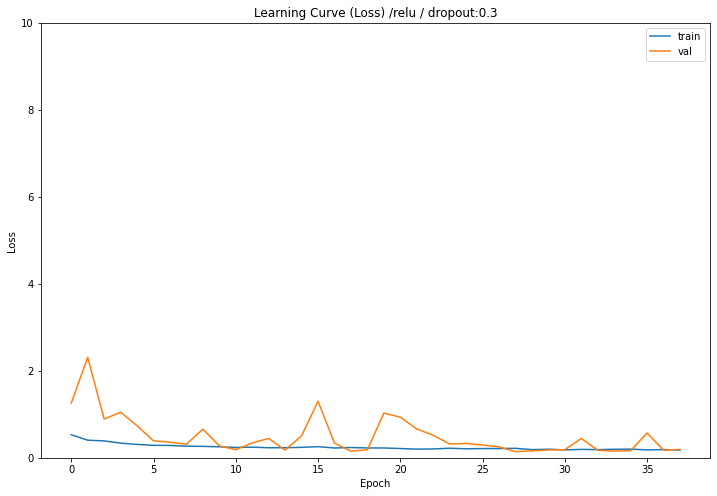

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss) /'+activation_list[0]+' / dropout:'+ str(dropout_rate))
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 10)
ax.legend(['train', 'val'], loc='best')
plt.show()

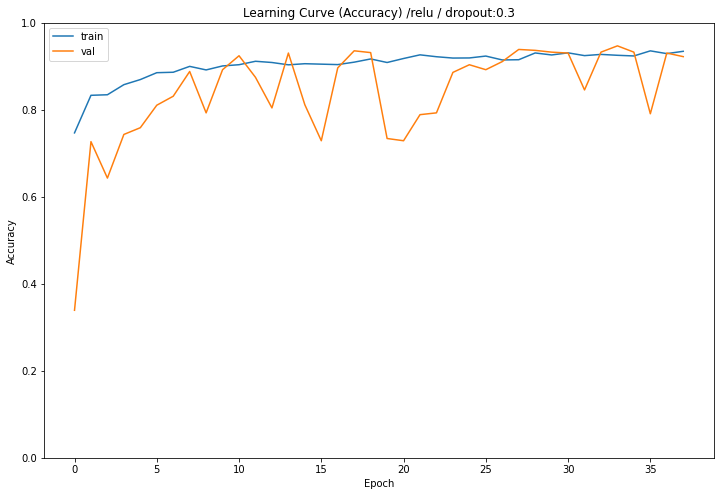

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy) /'+activation_list[0]+' / dropout:'+ str(dropout_rate))
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.00, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [16]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.1397113800048828
Val accuracy: 0.9389865398406982


In [17]:
score = model.evaluate(ds_test, steps = len(test_df), verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.16051726043224335
Test accuracy: 0.9440993666648865


## Confusion Matrix and ROC Curve

In [18]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = test_df['class'].copy().map(num_label).astype('int')

In [19]:
ds_test.reset()
predictions = model.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [20]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.9440993788819876


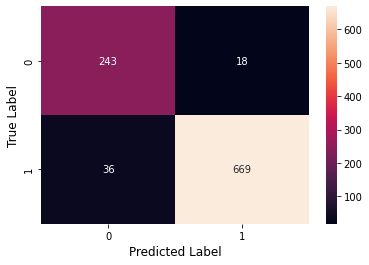

In [21]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [22]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       261
           1       0.97      0.95      0.96       705

    accuracy                           0.94       966
   macro avg       0.92      0.94      0.93       966
weighted avg       0.95      0.94      0.94       966



ROC_AUC:  0.9781690714926224


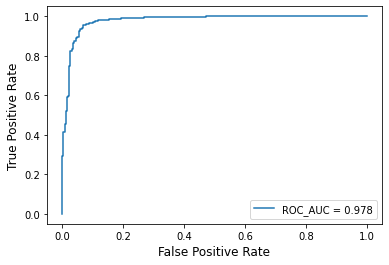

In [23]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()

In [24]:
#EOF